This notebook will be used to develop the reference values that will be measured by the temperature, pressure and flow sensors. The reference values will be transformed on the sensor simulator to emulate its measurements for a normal operation and fault conditions, such as overpressure and high decay rates.

First of all, we need to import the necessary libraries and define the constants that will be used in the simulation.

In [564]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

Then, we will define the reference values for the temperature, pressure and flow sensors. The reference values will be defined as a function of time, so we can simulate the variation of the values over time.

In [565]:
DEFAULT_STEP_AIR_FLOW = 0.05
DEFAULT_STEP_PRESSURE = 0.04
DEFAULT_STEP_TEMP = 0.8

DEFAULT_NOISE_LEVEL_AIR_FLOW = 0.05
DEFAULT_NOISE_LEVEL_PRESSURE = 0.01
DEFAULT_NOISE_LEVEL_TEMP= 1.2

DEFAULT_AIR_FLOW_VALUES = [
    (0, 0.3),
    (0.4, 0.3),
    (0.6, 3.3),
    (0.7, 2.2),
    (1.7, 1.7),
    (2.2, 1.6),
    (2.7, 1.7),
    (3.5, 1.6),
    (5, 1.6),
    (5.5, 1),
    (6, 0.7),
    (7, 0.3),
    (10, 0.3)
]

DEFAULT_TEMP_VALUES = [
    (0, 26),
    (4, 27),
    (8, 26),
    (9, 42),
    (10, 53),
    (11, 60),
    (12, 65),
    (13, 70),
    (14.2, 75),
    (15.5, 80),
    (17, 83),
    (19, 85),
    (22, 88),
    (25, 89),
    (30, 90),
    (46, 90),
    (48, 75),
    (49, 70),
    (51, 63),
    (52, 63),
    (53, 70),
    (55.5, 80),
    (57, 83),
    (59, 85),
    (62, 88),
    (65, 89),
    (80, 90),
    (86, 90),
    (88, 75),
    (89, 70),
    (91, 63),
    (93, 58),
    (97, 48),
    (100, 44),
    (105, 39),
    (110, 35), 
    (120, 30), 
    (140, 26),
    (150, 26)
]

DEFAULT_PRESSURE_VALUES = [
    (0, 0.1),
    (0.4, 0.1),
    (0.6, 1.6),
    (1.2, 1.6),
    (1.3, 0.82),
    (2.2, 0.8),
    (2.7, 0.82),
    (3.5, 0.8),
    (5, 0.8),
    (5.1, 0.5),
    (6, 0.5),
    (6.9, 0.5),
    (7, 0.1),
    (10, 0.1)
]

DEFAULT_VALUES = {
    'flow': (DEFAULT_STEP_AIR_FLOW, DEFAULT_NOISE_LEVEL_AIR_FLOW, DEFAULT_AIR_FLOW_VALUES),
    'temperature': (DEFAULT_STEP_TEMP, DEFAULT_NOISE_LEVEL_TEMP, DEFAULT_TEMP_VALUES),
    'pressure': (DEFAULT_STEP_PRESSURE, DEFAULT_NOISE_LEVEL_PRESSURE, DEFAULT_PRESSURE_VALUES)
}


In [566]:
def interpolate_with_noise(values, step=0.05, noise_level=0.1):
    interpolated_values = []
    for i in range(len(values) - 1):
        # Unpack the current and next tuple
        (t1, temp1), (t2, temp2) = values[i], values[i + 1]

        # Calculate the number of steps between the two times
        steps = range(1, int(round((t2 - t1) / step)))

        # Find the temperature difference and set a minimum difference threshold
        temps_diff = max(math.fabs(temp2 - temp1), 0.05)

        # Modify the noise level based on the temperature difference
        # The noise level is higher for smaller differences and lower for larger differences
        adjusted_noise_level = noise_level / (1 + temps_diff)

        # Generate the intermediate values with noise
        for i, s in enumerate(steps, start=1):
            # Calculate the intermediate time
            current_time = t1 + s * step

            # Linear interpolation formula
            current_temp = temp1 + ((temp2 - temp1) / (t2 - t1)) * (current_time - t1)

            denominator = math.exp(-i + 1) + 1.5

            # Introduce noise
            noise = random.uniform(-adjusted_noise_level/denominator, adjusted_noise_level/denominator)
            current_temp_with_noise = current_temp + noise

            # Append the interpolated value to the list
            interpolated_values.append((round(current_time, 2), current_temp_with_noise))

        # Add the last value of the current interval if it's not the last tuple
        if i < len(values) - 2:
            interpolated_values.append((t2, temp2 + random.uniform(-adjusted_noise_level, adjusted_noise_level)))

    # Append the last value of the entire sequence with noise
    final_time, final_temp = values[-1]
    interpolated_values.append((final_time, final_temp + random.uniform(-adjusted_noise_level, adjusted_noise_level)))

    return interpolated_values

def draw_plot(x, y, title, xlabel, ylabel, color, size_multiplier=(1, 1), reference_values = []):
    # Plotting the graph

    x_mult, y_mult = size_multiplier
    
    if x_mult != 1:
        x_mult = 3 if x_mult > 3 else x_mult
        plt.figure().set_figwidth(6.4*x_mult)

    if y_mult != 1:
        y_mult = 3 if y_mult > 3 else y_mult
        plt.figure().set_figheight(4.8*y_mult)
        
    plt.plot(x, y, label=title, color=color)

    if reference_values != []:
        # Plott the reference values first
        plt.plot([t for t, _ in reference_values], [v for _, v in reference_values], label='Reference', color='red', linestyle='dashed')


    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.ylim(0, None)
    plt.xlim(0, None)
    plt.legend()
    plt.show()
    
class IncrementalFaultValue:
    def __init__(self, target, step = 0.5, time = 10, time_step = 0.1) -> None:
        """
        Step: the multiplier of target to increment the value.
        """
        self.value = 0
        self.target = target
        self.step = step * time_step
        self.time = time
        self.time_step = time_step
        self.curr_time = 0
        self.adjust_to_target = True # Will aim to the target, if False, it will retract to 0
        self.time_to_retract = self.time*step
    
    def _update_time(self):
        self.curr_time += self.time_step
        if self.time - self.time_to_retract <= self.curr_time:
            self.adjust_to_target = False

    def _update_value(self):
        self._update_time()
        print(round(self.curr_time,2), round(self.time_to_retract,2), self.adjust_to_target, self.value)
        if self.adjust_to_target:
            self.value = self.value + self.step if self.value + self.step <= self.target else self.target
        else:
            self.value = self.value - self.step if self.value - self.step >= 0 else 0

    def get_current_value(self):
        """
        The value is updated every time this method is called.
        """
        self._update_value()
        return self.value

def simulate_temperature_faults(values = DEFAULT_TEMP_VALUES.copy(), fault_rate = 0.1, fault_duration= 0.25, fault_type = 'distinct', step = 0.05):
    """
    Simulate temperature faults.
    After the system enters a fault state, the kind of failure is chosen randomly and stays in that state for a random time.
    fault_type: 'continuous', 'distinct'. Continuous faults are not reset until the end of the simulation.
    """

    # Initialize the result array with the original air_flow_values
    result = []

    # Initialize the fault state
    fault_state = 'normal'

    # Initialize the fault timer
    fault_timer = 0

    min_temp = min([v for _, v in values])
    max_temp = max([v for _, v in values])
    value_interval = max_temp - min_temp
    time_interval = values[-1][0] - values[0][0]
    target_fault_value = value_interval/8
    incremental_fault_value = IncrementalFaultValue(target_fault_value, step = 0.05, time = int(time_interval*fault_duration), time_step = step)

    print(time_interval, time_interval*fault_duration)

    # Iterate over the original values
    for (t, v) in values:
        # If the system is in a fault state
        if fault_state != 'normal':
            # If the fault timer has reached 0, the system is back to normal
            if fault_type == 'distinct':
                if fault_timer == 0:
                    fault_state = 'normal'
                else:
                    # Otherwise, the fault timer is decremented
                    fault_timer -= 1
        else:
            # Otherwise, the system is normal and a fault can occur
            if random.random() < fault_rate:
                # If a fault occurs, the fault state is set to a random value

                if v < min_temp + 5:
                    fault_state = 'high'
                elif v > max_temp - 5:
                    fault_state = 'low'
                else:
                    fault_state = random.choice(['high', 'low'])

                # The fault timer is set to a random value
                fault_timer = random.randint(1, int(time_interval/6))

        # If the system is in a fault state, the value is modified
        if fault_state == 'high':
            v += incremental_fault_value.get_current_value()
        elif fault_state == 'low':
            v -= incremental_fault_value.get_current_value()

        # The value is appended to the result
        result.append((t, v))

    return result, fault_state

def repeat_values_n_times(values, N):

    if N <= 1:
        return values

    timestamp_increment = values[-1][0]
    
    # Initialize the result array with the original air_flow_values
    result = values[:]
    
    for i in range(1, N):
        # Create the new repeated sequence, adjusting timestamps with the increment
        new_sequence = [(t + i * timestamp_increment, v) for t, v in values[1:]]
        # Append the new sequence to the result
        result.extend(new_sequence)
    
    return result

def draw_values_graph(values = [], repeat:int = 1, step:float = 0.05, noise_level:float = 0.1, func = interpolate_with_noise, type = 'flow', title = '', show_reference = False, fault_rate = 0.0):
    """
    type: 'flow', 'pressure', 'temperature'
    """

    gen_values = repeat_values_n_times(values, repeat)

    interpolated_values = func(gen_values, step, noise_level)

    interpolated_values, _ = simulate_temperature_faults(interpolated_values, fault_rate = fault_rate)

    # Separate the time and values for plotting
    times = [time for time, _ in interpolated_values]
    temperatures = [temp for _, temp in interpolated_values]

    xlabel = 'Time (s)'
    ylabel = ''
    color = 'blue'
    match type:
        case 'flow':
            ylabel = 'L/min'
            title = 'Reference Air Flow' if title == '' else title
        case 'pressure':
            ylabel = 'MPa'
            title = 'Reference Pressure' if title == '' else title
        case 'temperature':
            ylabel = 'T °C'
            title = 'Reference Temperature' if title == '' else title

    if show_reference:
        ref_step, ref_noise_level, values = DEFAULT_VALUES[type]

        gen_values = repeat_values_n_times(values, repeat)

        reference_values = func(gen_values, ref_step, ref_noise_level)
        draw_plot(times, temperatures, title, xlabel, ylabel, color, size_multiplier=(repeat, 1), reference_values=reference_values)
    else:
        draw_plot(times, temperatures, title, xlabel, ylabel, color, size_multiplier=(repeat, 1))

In [567]:
def draw_reference_graphs(type = ''):
    match type:
        case 'flow':
            step, noise_level, values = DEFAULT_VALUES[type]
        case 'pressure':
            step, noise_level, values = DEFAULT_VALUES[type]
        case 'temperature':
            step, noise_level, values = DEFAULT_VALUES[type]
        case _:
            draw_reference_graphs('flow')
            draw_reference_graphs('pressure')
            draw_reference_graphs('temperature')
            return
            
    draw_values_graph(values, 1, step = step, noise_level = noise_level, func = interpolate_with_noise, type=type, show_reference = False)


In [568]:
# draw_reference_graphs()

19.95 4.9875
0.05 0.2 True 0
0.1 0.2 True 0.0025000000000000005
0.15 0.2 True 0.005000000000000001
0.2 0.2 True 0.0075000000000000015
0.25 0.2 True 0.010000000000000002
0.3 0.2 True 0.012500000000000002
0.35 0.2 True 0.015000000000000003
0.4 0.2 True 0.0175
0.45 0.2 True 0.020000000000000004
0.5 0.2 True 0.022500000000000006
0.55 0.2 True 0.02500000000000001
0.6 0.2 True 0.02750000000000001
0.65 0.2 True 0.030000000000000013
0.7 0.2 True 0.032500000000000015
0.75 0.2 True 0.03500000000000002
0.8 0.2 True 0.03750000000000002
0.85 0.2 True 0.04000000000000002
0.9 0.2 True 0.042500000000000024
0.95 0.2 True 0.045000000000000026
1.0 0.2 True 0.04750000000000003
1.05 0.2 True 0.05000000000000003
1.1 0.2 True 0.05250000000000003
1.15 0.2 True 0.055000000000000035
1.2 0.2 True 0.05750000000000004
1.25 0.2 True 0.06000000000000004
1.3 0.2 True 0.06250000000000004
1.35 0.2 True 0.06500000000000004
1.4 0.2 True 0.06750000000000005
1.45 0.2 True 0.07000000000000005
1.5 0.2 True 0.0725000000000000

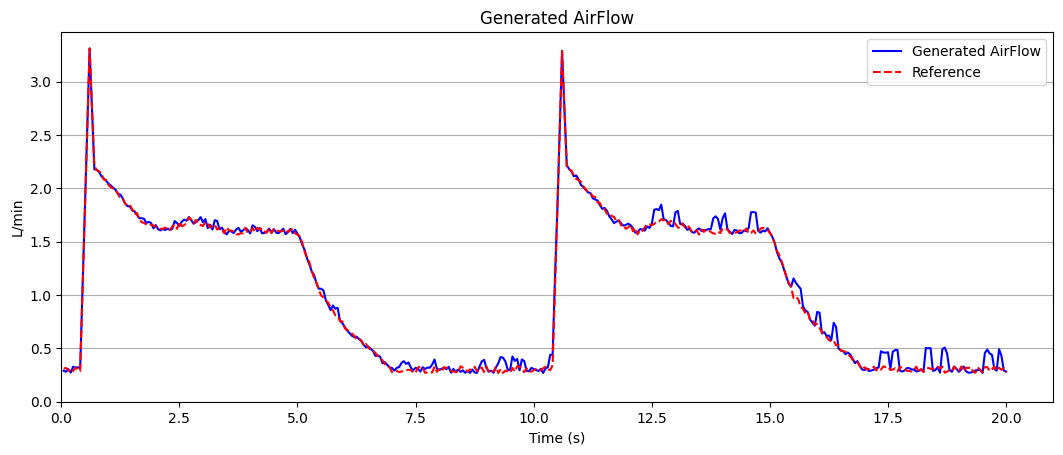

In [569]:
repeat = 2

air_flow_values = DEFAULT_AIR_FLOW_VALUES.copy()
pressure_values = DEFAULT_PRESSURE_VALUES.copy()
temperature_values = DEFAULT_TEMP_VALUES.copy()

draw_values_graph(air_flow_values, repeat, step = DEFAULT_STEP_AIR_FLOW, noise_level = DEFAULT_NOISE_LEVEL_AIR_FLOW, func = interpolate_with_noise, type='flow', title="Generated AirFlow", show_reference = True, fault_rate=0.1)
# draw_values_graph(pressure_values, repeat, step = DEFAULT_STEP_PRESSURE, noise_level = DEFAULT_NOISE_LEVEL_PRESSURE*5, func = interpolate_with_noise, type='pressure', title="Generated Pressure", show_reference = True)
# draw_values_graph(temperature_values, repeat, step = DEFAULT_STEP_TEMP, noise_level = DEFAULT_NOISE_LEVEL_TEMP*5, func = interpolate_with_noise, type='temperature', title="Generated Temperature", show_reference = True)

With the reference values defined, let's start working on creating the following types of faults:
- Temperature:
    - Overtemperature &rarr; Leads to system failure
    - Undertemperature &rarr; Leads to inneficiency
    - Low decay rate &rarr; Will keep the system working at a higher temperature than normal
- Pressure:
    - Overpressure &rarr; Leads to system failure
    - Underpressure &rarr; Leads to system failure
    - Low decay rate &rarr; Need of maintenance
- Flow:
    - Overflow &rarr; Leads to system failure
    - Underflow &rarr; Leads to inneficiency and system failure
    - High/Low decay rate &rarr; Need of maintenance 

In [570]:
class IncrementalFaultValue:
    def __init__(self, target, step = 0.5, time = 10) -> None:
        """
        Step: the multiplier of target to increment the value.
        """
        self.value = 0
        self.target = target
        self.step = step
        self.time = time
        self.curr_time = 0
        self.adjust_to_target = True # Will aim to the target, if False, it will retract to 0
        
        self.time_to_retract = self.time*self.step
        
        if self.time_to_retract > self.time:
            self.time_to_retract = self.time
    
    def _update_time(self):
        self.curr_time += 1
        if self.time - self.time_to_retract <= self.curr_time:
            self.adjust_to_target = False

    def _update_value(self):
        self._update_time()
        if self.adjust_to_target:
            self.value = self.value + self.step if self.value + self.step <= self.target else self.value
        else:
            self.value = self.value - self.step if self.value - self.step >= 0 else self.value

    def get_current_value(self):
        """
        The value is updated every time this method is called.
        """
        self._update_value()
        return self.value

def simulate_temperature_faults(values = DEFAULT_TEMP_VALUES.copy(), fault_rate = 0.1, fault_duration= 0.5, fault_type = 'distinct'):
    """
    Simulate temperature faults.
    After the system enters a fault state, the kind of failure is chosen randomly and stays in that state for a random time.
    fault_type: 'continuous', 'distinct'. Continuous faults are not reset until the end of the simulation.
    """

    # Initialize the result array with the original air_flow_values
    result = []

    # Initialize the fault state
    fault_state = 'normal'

    # Initialize the fault timer
    fault_timer = 0

    min_temp = min([v for _, v in values])
    max_temp = max([v for _, v in values])
    value_interval = max_temp - min_temp
    time_interval = values[-1][0] - values[0][0]
    target_fault_value = value_interval/8
    incremental_fault_value = IncrementalFaultValue(target_fault_value, step = 0.25, time = int(time_interval*fault_duration))

    print(target_fault_value)

    # Iterate over the original values
    for (t, v) in values:
        # If the system is in a fault state
        if fault_state != 'normal':
            # If the fault timer has reached 0, the system is back to normal
            if fault_type == 'distinct':
                if fault_timer == 0:
                    fault_state = 'normal'
                else:
                    # Otherwise, the fault timer is decremented
                    fault_timer -= 1
        else:
            # Otherwise, the system is normal and a fault can occur
            if random.random() < fault_rate:
                # If a fault occurs, the fault state is set to a random value

                if v < min_temp + 5:
                    fault_state = 'high'
                elif v > max_temp - 5:
                    fault_state = 'low'
                else:
                    fault_state = random.choice(['high', 'low'])

                # The fault timer is set to a random value
                fault_timer = random.randint(1, int(time_interval/6))

        # If the system is in a fault state, the value is modified
        if fault_state == 'high':
            v += incremental_fault_value.get_current_value()
        elif fault_state == 'low':
            v -= incremental_fault_value.get_current_value()

        # The value is appended to the result
        result.append((t, v))

    return result, fault_state


8.0
[(0, 26), (4, 27), (8, 26), (9, 42), (10, 52.75), (11, 59.5), (12, 64.25), (13, 69.0), (14.2, 73.75), (15.5, 78.5), (17, 81.25), (19, 83.0), (22, 85.75), (25, 86.5), (30, 87.25), (46, 87.0), (48, 71.75), (49, 66.5), (51, 59.25), (52, 59.0), (53, 65.75), (55.5, 75.5), (57, 78.25), (59, 80.0), (62, 82.75), (65, 83.5), (80, 90), (86, 90), (88, 75), (89, 70), (91, 63), (93, 58), (97, 48), (100, 44), (105, 33.25), (110, 29.0), (120, 23.75), (140, 19.5), (150, 19.25)]
8.989409310945728


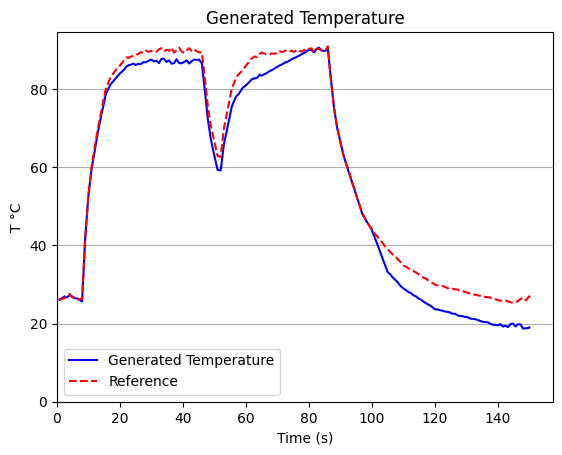

In [571]:
repeat = 1

values, _fault_state = simulate_temperature_faults(fault_rate=0.1, fault_duration = 0.25)

print(values)

draw_values_graph(values, repeat, step = DEFAULT_STEP_TEMP, noise_level = DEFAULT_NOISE_LEVEL_TEMP, func = interpolate_with_noise, type='temperature', title="Generated Temperature", show_reference = True)